# 📈 Exploração de Dados e Modelo LSTM (PyTorch)
Notebook para análise inicial, coleta, visualização e treino preliminar com LSTM.

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
symbol = 'NVDA'
df = yf.download(symbol, start='2020-01-01', end='2025-12-01')
features = ['Open', 'High', 'Low', 'Close', 'Volume']
df = df[features].dropna()
df.head()

/tmp/ipython-input-497715960.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start='2020-01-01', end='2025-12-01')
[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2020-01-02,5.942538,5.971410,5.892011,5.971410,237536000
2020-01-03,5.851688,5.919638,5.826797,5.875831,205384000
2020-01-06,5.782494,5.905700,5.756359,5.900473,262636000
2020-01-07,5.928847,6.017706,5.883796,5.971908,314856000
2020-01-08,5.967676,6.024425,5.927603,5.983108,277108000


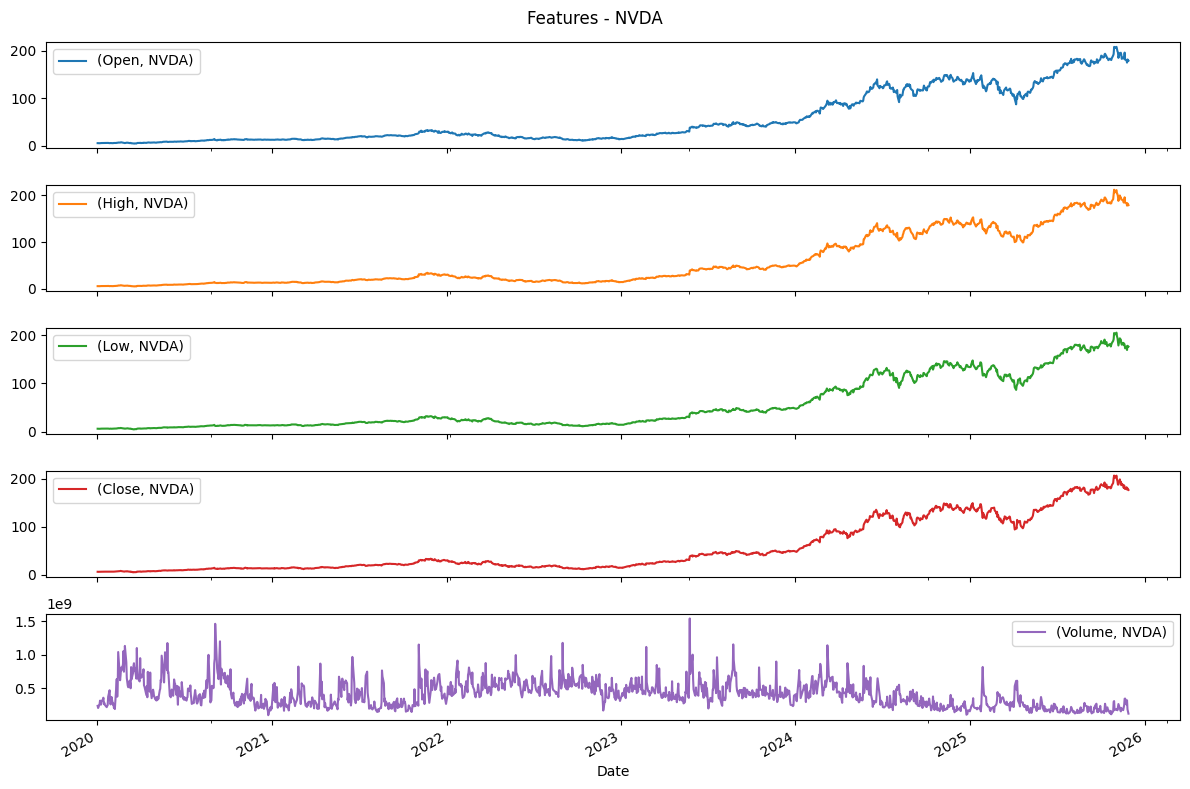

In [3]:
df[features].plot(figsize=(12,8), subplots=True, title=f'Features - {symbol}')
plt.tight_layout()
plt.show()

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
def create_sequences(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])  # Todas as features como input
        y.append(data[i, 3])  # Apenas 'Close' (índice 3) como target
    return np.array(X), np.array(y)
X, y = create_sequences(scaled)
print(f'X shape: {X.shape} (samples, timesteps, features)')
print(f'y shape: {y.shape} (samples,)')

X shape: (1426, 60, 5) (samples, timesteps, features)
y shape: (1426,) (samples,)


In [5]:
import torch
import torch.nn as nn
class LSTMModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)
model = LSTMModel(input_size=5)  # 5 features: Open, High, Low, Close, Volume
print(f'Model input size: 5 features')

Model input size: 5 features


In [6]:
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Adiciona dimensão para compatibilidade
dataset = torch.utils.data.TensorDataset(X_t, y_t)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
print(f'X_t shape: {X_t.shape}')
print(f'y_t shape: {y_t.shape}')

X_t shape: torch.Size([1426, 60, 5])
y_t shape: torch.Size([1426, 1])


In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 5
for epoch in range(epochs):
    for xb, yb in loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.5f}')

Epoch 1, Loss: 0.00162
Epoch 2, Loss: 0.00361
Epoch 3, Loss: 0.00046
Epoch 4, Loss: 0.00072
Epoch 5, Loss: 0.00050


## ✔ Treinamento concluído! Agora você pode exportar o modelo ou seguir para tuning.